In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
import datetime
import h5py
from scipy.stats.stats import pearsonr
from skimage import measure
import pandas
import pytorch_ssim

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [4]:
no_cuda=False
cuda = not no_cuda and torch.cuda.is_available()
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
EPOCH = 50
LR=0.0001
L2=0.0
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    

In [5]:
def img_real2view(img):
    gamma_correction=lambda x:np.power(x,1.0/2.2)
    img_shape=img.shape
    # gray image
    if np.size(img_shape)==2:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#float32, 1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)
    #color image
    if np.size(img_shape)==3:
        #uint8
        if np.max(img)>1:
            temp_view=np.zeros_like(img,dtype=np.float32)
            temp_view=np.float32(img)/255.0#1.0
            temp_view=gamma_correction(temp_view)
            temp_view2=np.zeros_like(img,dtype=np.uint8)
            temp_view2=np.uint8(temp_view*255)#255
            return temp_view2
        #float
        if np.max(img)<2:
            return gamma_correction(img)

In [6]:
#read movie data
def read_movie_from_h5(filename):
    h5f = h5py.File(filename,'r')
    movie_bgr_h5=h5f['movie_bgr_real'][:]
    h5f.close()
    return movie_bgr_h5
movie_bgr_h5=read_movie_from_h5('../data/all_image_patches_upper_1f_28x28_bg_20200512.h5') 
print (movie_bgr_h5.shape)

(10000, 28, 28, 2)


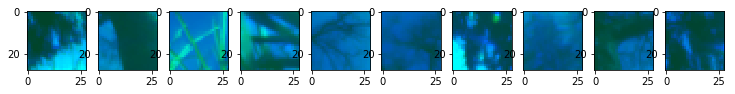

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=movie_bgr_h5[5000+ii,:,:,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)

In [8]:
#make train, val, test loader, make the dataset suitable for pytorch
movie_bgr_h5=np.transpose(movie_bgr_h5,(0,3,1,2))
train_loader=[]
for ii in range(0,9000,100):
    temp0=movie_bgr_h5[ii:ii+100]
    train_loader.append(temp0)

temp0=movie_bgr_h5[9000:9800]
val_loader=np.copy(temp0)
temp0=movie_bgr_h5[9800:]
test_loader=np.copy(temp0)

print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0]:')
print (train_loader[0].shape)
print ('shape of val_loader:')
print (val_loader.shape)
print ('shape of test_loader:')
print (test_loader.shape)

length of train_loader:
90
shape of train_loader[0]:
(100, 2, 28, 28)
shape of val_loader:
(800, 2, 28, 28)
shape of test_loader:
(200, 2, 28, 28)


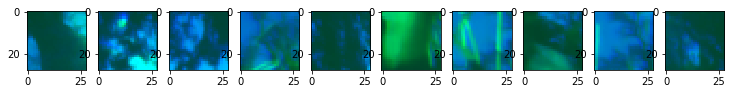

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(train_loader[10][ii],(1,2,0))[...,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)

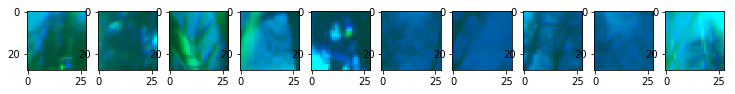

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(test_loader[ii],(1,2,0))[...,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)

In [11]:
#define train_loader_length and val_loader_length for function model_train()
train_loader_length=len(train_loader)
val_loader_length=len(val_loader)
sky_bg_mean_f   =(0.2880458268307323, 0.18039892206882754)

In [12]:
#some help function
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)  

class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

loss_mse = nn.MSELoss()
loss_ssim = pytorch_ssim.SSIM(window_size=3)

#loss with L2 and L1 regularizer
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempN=x.shape[0]
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    L1loss=beta*F.l1_loss(beta_y,torch.zeros_like(beta_y),reduction='sum')
    return (MSE+L2loss+L1loss)/(tempN*10*2*56*56)#batch size tempN, to be comparable with other ae variants loss

#loss with L2 and L1 regularizer, version2
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1v2(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempD, tempH, tempW =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    B, C, D, H, W = beta_y.size() 
    temp1=beta_y.view(B,C,-1)
    temp2=torch.norm(temp1,p=2,dim=2)
    temp3=torch.sum(torch.abs(temp2))
    L1loss=beta*temp3
    return (MSE+L2loss+L1loss)/(tempB* tempC* tempD* tempH* tempW)

#loss with L2 and L1 regularizer, for AE
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
def loss_L2L1_FC(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempH, tempW =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempC* tempH* tempW)
def loss_L2L1_FC_ssim(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempH, tempW =x.size()
    MSE = -pytorch_ssim.ssim(recon_x, x,window_size=3)
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.norm(1)
    L1loss=beta*l1temp
    return MSE+(L2loss+L1loss)/(tempB* tempC* tempH* tempW)

#loss with L2 and L1 regularizer, for AE without fully connective layer
#something like loss = mseloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
#beta_y is encoded output
def loss_L2L1_NoFC(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempH, tempW =x.size()
    MSE = F.mse_loss(recon_x, x,reduction='sum')
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.norm(1)
    L1loss=beta*l1temp
    return (MSE+L2loss+L1loss)/(tempB* tempC* tempH* tempW)

class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach

    def forward(self, x):
        if self.training and self.sigma != 0:
            sampled_noise = torch.randn(x.size(),requires_grad=False).to(device)* self.sigma
            x = x + x*sampled_noise
        return x 

#loss with L2 and L1 regularizer, for AE without fully connective layer
#something like loss = ssimloss+ alpha*alpha_x(L2)+beta*beta_y(L1), here alpha_x is a list of model layers
#beta_y is encoded output
def loss_L2L1_NoFC_ssim(recon_x, x, alpha, beta, alpha_x, beta_y):
    tempB, tempC, tempH, tempW =x.size()
    MSE = -pytorch_ssim.ssim(recon_x, x,window_size=3)
    l2temp=0.0
    for temp in alpha_x:
        l2temp = l2temp+ temp.weight.norm(2)
    L2loss=alpha*l2temp
    l1temp=0.0
    for temp in beta_y:
        l1temp = l1temp+ temp.norm(1)
    L1loss=beta*l1temp
    return MSE+(L2loss+L1loss)/(tempB* tempC* tempH* tempW)

# <font color='red'> AE</font>
## spatial, mse loss

In [13]:
class Autoencoder18_FC(nn.Module):
    def __init__(self):
        super(Autoencoder18_FC, self).__init__()
        self.conv1 =nn.Conv2d(2,16,kernel_size=9,stride=1,padding=4) #16,28*28
        self.dconv1=nn.ConvTranspose2d(16,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.fc1   =nn.Linear(16*28*28,16*28*28)
        self.dfc1  = nn.Linear(16*28*28,16*28*28)
        # 压缩
        self.encoder = nn.Sequential(
            self.conv1, #16,28*28
            nn.ReLU(),
            Flatten(),
            self.fc1,
            nn.ReLU(),
            GaussianNoise(sigma=1)
        )
        # 解压
        self.decoder = nn.Sequential(
            self.dfc1,
            nn.ReLU(),
            Unflatten(-1,16,28,28),
            self.dconv1, #2,28*28
            #nn.Sigmoid(),       
            nn.Tanh()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [14]:
#function for training
def model_train(model,data,optimizer,device,EPOCH,loss_func,alpha=None,beta=None):
    print(datetime.datetime.now())
    model=model.to(device)
    model=model.train()
    loss=0.0
    train_loss=0.0
    for epoch in range(EPOCH):
        for step, x in enumerate(data):
            x=x/255.0
            x[:,0,:,:]=x[:,0,:,:]-sky_bg_mean_f[0]
            x[:,1,:,:]=x[:,1,:,:]-sky_bg_mean_f[1]
            b_x = torch.from_numpy(x).float().to(device) 
            b_y = torch.from_numpy(x).float().to(device) 
            if 'dn' in model.__class__.__name__:
                b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
                b_x=torch.clamp(b_x,min=-1.0,max=1.0)
            if 'VariationalAE' in model.__class__.__name__:
                encoded, mu, logvar, decoded = model(b_x)
                loss = loss_func(decoded, b_y, mu, logvar,beta)
            if 'L2L1' in model.__class__.__name__:
                encoded, decoded = model(b_x)
                loss=loss_func(decoded, b_y,alpha,beta,[model.conv1,model.dconv1],\
                               encoded)
            if 'FC' in model.__class__.__name__:
                encoded, decoded = model(b_x)
                loss=loss_func(decoded, b_y,alpha,beta,[model.conv1,model.dconv1],\
                               encoded)
            if epoch==EPOCH-1:
                train_loss=train_loss+loss.cpu().data.numpy()
            optimizer.zero_grad()               
            loss.backward()                     
            optimizer.step()                    
            if step % 100 == 0:
                print('Model: ',model.__class__.__name__,'|Epoch: ', epoch,\
                      '| train loss: %.4f' % loss.cpu().data.numpy())
    print ('finish training!')
    print(datetime.datetime.now())
    train_loss=train_loss/len(data)
    print ('Model: ',model.__class__.__name__,'|train loss: %.4f' % train_loss)
    return train_loss

In [15]:
#use the trained model to test the validation loss
#val_eg: the example used to show results
def model_val(model,data,val_eg,device,loss_func):
    model=model.to(device)
    model=model.eval()
    data=data/255.0
    x=data
    x[:,0,:,:]=x[:,0,:,:]-sky_bg_mean_f[0]
    x[:,1,:,:]=x[:,1,:,:]-sky_bg_mean_f[1]
    b_x = torch.from_numpy(x).float().to(device) 
    b_y = torch.from_numpy(x).float().to(device)
    if 'dn' in model.__class__.__name__:
        b_x=b_x+0.05*torch.randn(b_x.size()).to(device)
        b_x=torch.clamp(b_x,min=-1.0,max=1.0)
    if 'VariationalAE' in model.__class__.__name__:
        encoded, mu, logvar, decoded = model(b_x)
        val_loss = loss_func(decoded, b_y, mu, logvar,0)
    else:
        encoded,decoded = model(b_x)
        val_loss=loss_func(decoded, b_y)
    print ('Model: ',model.__class__.__name__,'|validation loss: %.4f' % val_loss.cpu().data.numpy())
    x[:,0,:,:]=x[:,0,:,:]+sky_bg_mean_f[0]
    x[:,1,:,:]=x[:,1,:,:]+sky_bg_mean_f[1]
    fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(15,3))
    for jj in range(10):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.uint8(np.transpose(x[val_eg+jj],(1,2,0))[...,::-1]*255)
        axes[0,jj].imshow(img_real2view(temp))
        axes[0,jj].grid(False)#axes[ii,jj].axis('tight')
        if jj==0:
            axes[0,jj].set_title('Target')
    decoded_np=decoded.cpu().data.numpy()
    decoded_np[:,0,:,:]=decoded_np[:,0,:,:]+sky_bg_mean_f[0]
    decoded_np[:,1,:,:]=decoded_np[:,1,:,:]+sky_bg_mean_f[1]
    decoded_np= np.clip(decoded_np, 0.0, 1.0)
    for jj in range(10):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.uint8(np.transpose(decoded_np[val_eg+jj],(1,2,0))[...,::-1]*255)
        axes[1,jj].imshow(img_real2view(temp))
        axes[1,jj].grid(False)#axes[ii,jj].axis('tight')
        if jj==0:
            axes[1,jj].set_title('Predict')
    return val_loss.cpu().data.numpy()

In [16]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle):
    #UV channel
    (outd,ind,_,_)=conv3d_0.shape
    '''
    fig, axes = plt.subplots(nrows=int(outd/8), ncols=8,figsize=(10, int(outd/8)))
    for ii in range(int(outd/8)):
        for jj in range(8):
            #temp=np.max([np.abs(np.min(conv3d_0[ii*8+jj,0,...])),np.abs(np.max(conv3d_0[ii*8+jj,0,...]))])
            #weight_min=-temp
            #weight_max=temp
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,0,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
            if ii==0 and jj==0:
                axes[ii,jj].set_title(str(temptitle))
    #G channel
    weight_min=np.min(conv3d_0) #np.min(conv3d_0[:,1,...])
    weight_max=np.max(conv3d_0) #np.max(conv3d_0[:,1,...])
    if weight_max>(weight_min*(-1.0)):
        weight_min=weight_max*(-1.0)
    if weight_max<(weight_min*(-1.0)):
        weight_max=weight_min*(-1.0)
    fig, axes = plt.subplots(nrows=int(outd/8), ncols=8,figsize=(10, int(outd/8)))
    for ii in range(int(outd/8)):
        for jj in range(8):
            #temp=np.max([np.abs(np.min(conv3d_0[ii*8+jj,1,...])),np.abs(np.max(conv3d_0[ii*8+jj,1,...]))])
            #weight_min=-temp
            #weight_max=temp
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,1,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
    '''   
    fig, axes = plt.subplots(nrows=2, ncols=outd,figsize=(outd, 2))
    for jj in range(outd):
        weight_max=np.max(np.abs(conv3d_0[jj,...]))
        axes[0,jj].imshow(conv3d_0[jj,0,...],vmin=-weight_max,vmax=weight_max,cmap='bwr')#UV
        axes[0,jj].set_xticks([]),axes[0,jj].set_yticks([])
        if jj==0:
            axes[0,jj].set_title(str(temptitle))
        axes[1,jj].imshow(conv3d_0[jj,1,...],vmin=-weight_max,vmax=weight_max,cmap='bwr')#G
        axes[1,jj].set_xticks([]),axes[1,jj].set_yticks([])
    #plt.tight_layout()
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
    #fig.colorbar(im, cax=cbar_ax)
    #fig.savefig('./out/ae3D_4_wL2_initDefault_sky_conv3d_0.svg')

In [17]:
#using pearson correlation as metric
def model_test(model,data,test_eg,device,loss_func):
    model=model.to(device)
    model=model.eval()
    data=data/255.0
    x=data
    x[:,0,:,:]=x[:,0,:,:]-sky_bg_mean_f[0]
    x[:,1,:,:]=x[:,1,:,:]-sky_bg_mean_f[1]
    b_x = torch.from_numpy(x).float().to(device) 
    b_y = torch.from_numpy(x).float().to(device)
    encoded,decoded = model(b_x)
    test_loss=loss_func(decoded, b_y)
    print ('Model: ',model.__class__.__name__,'|test loss: %.4f' % test_loss.cpu().data.numpy())
    x[:,0,:,:]=x[:,0,:,:]+sky_bg_mean_f[0]
    x[:,1,:,:]=x[:,1,:,:]+sky_bg_mean_f[1]
    fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(15,3))
    for jj in range(10):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.uint8(np.transpose(x[test_eg+jj],(1,2,0))[...,::-1]*255)
        axes[0,jj].imshow(img_real2view(temp))
        axes[0,jj].grid(False)#axes[ii,jj].axis('tight')
        if jj==0:
            axes[0,jj].set_title('Target')
    decoded_np=decoded.cpu().data.numpy()
    decoded_np[:,0,:,:]=decoded_np[:,0,:,:]+sky_bg_mean_f[0]
    decoded_np[:,1,:,:]=decoded_np[:,1,:,:]+sky_bg_mean_f[1]
    decoded_np= np.clip(decoded_np, 0.0, 1.0)
    for jj in range(10):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.transpose(decoded_np[test_eg+jj],(1,2,0))[...,::-1]
        axes[1,ii].imshow(img_real2view(temp))
        axes[1,jj].grid(False)
        if jj==0:
            axes[1,jj].set_title('Predict')
    return test_loss.cpu().data.numpy()

## Autoencoder18_FC(), mse loss, without BatchNorm, FC

In [ ]:
EPOCH = 100
alphas=[ 0,   1e2,  1e3,   1e4,  1e5] 
betas =[ 0, 1/256, 1/64,  1/16,  1/4] 
modeltrainloss=[]
modelvalloss=[]
for ii in range(len(alphas)):
    for jj in range(len(betas)):
        modelname=str(ii*len(betas)+jj+1)
        torch.manual_seed(1)    
        torch.cuda.manual_seed(1)
        tempmodel = Autoencoder18_FC()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        temp=model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_L2L1_FC,alpha=alphas[ii],beta=betas[jj])
        modeltrainloss.append(temp)
        torch.save(tempmodel.state_dict(), 'out/ae_18_FC_upper_thresh_mse_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,20,device,loss_mse)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

2020-05-12 15:38:47.840404
Model:  Autoencoder18_FC |Epoch:  0 | train loss: 0.0527
Model:  Autoencoder18_FC |Epoch:  1 | train loss: 0.0082
Model:  Autoencoder18_FC |Epoch:  2 | train loss: 0.0060
Model:  Autoencoder18_FC |Epoch:  3 | train loss: 0.0054
Model:  Autoencoder18_FC |Epoch:  4 | train loss: 0.0045
Model:  Autoencoder18_FC |Epoch:  5 | train loss: 0.0041
Model:  Autoencoder18_FC |Epoch:  6 | train loss: 0.0038
Model:  Autoencoder18_FC |Epoch:  7 | train loss: 0.0037
Model:  Autoencoder18_FC |Epoch:  8 | train loss: 0.0035
Model:  Autoencoder18_FC |Epoch:  9 | train loss: 0.0033
Model:  Autoencoder18_FC |Epoch:  10 | train loss: 0.0034
Model:  Autoencoder18_FC |Epoch:  11 | train loss: 0.0031
Model:  Autoencoder18_FC |Epoch:  12 | train loss: 0.0032
Model:  Autoencoder18_FC |Epoch:  13 | train loss: 0.0029
Model:  Autoencoder18_FC |Epoch:  14 | train loss: 0.0028
Model:  Autoencoder18_FC |Epoch:  15 | train loss: 0.0028
Model:  Autoencoder18_FC |Epoch:  16 | train loss: 0.00

In [19]:
print (np.reshape(np.array(modeltrainloss),(5,5)))
print (np.reshape(np.array(modelvalloss),(5,5)))

[[0.00136326 0.00180443 0.00231961 0.00417747 0.01558335]
 [0.00280364 0.0035398  0.0039694  0.00591393 0.01915522]
 [0.00381933 0.00454275 0.00548205 0.00776079 0.02315417]
 [0.00827521 0.00877904 0.00994634 0.01246327 0.0279248 ]
 [0.01791724 0.01843316 0.01965562 0.02294417 0.04736892]]
[[0.00380706 0.00506579 0.00449839 0.00528858 0.01210156]
 [0.0024515  0.00318816 0.00401861 0.00392512 0.01381579]
 [0.00260588 0.00276902 0.00341449 0.00478181 0.01693563]
 [0.00591029 0.00582587 0.00630305 0.00776463 0.0208086 ]
 [0.01330318 0.01296156 0.01374034 0.01532228 0.0436161 ]]


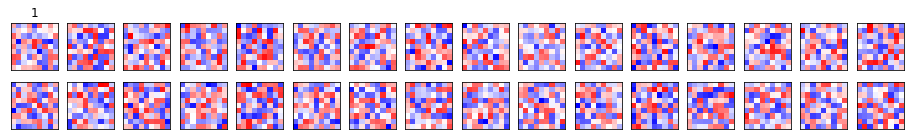

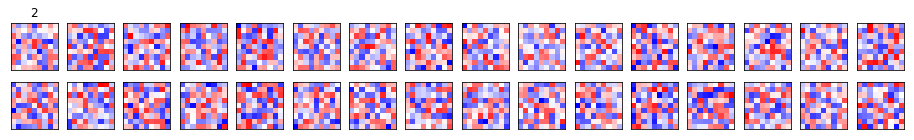

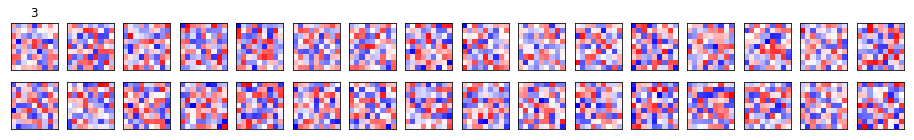

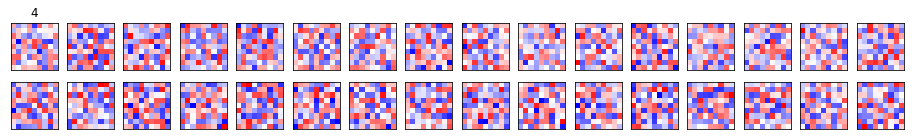

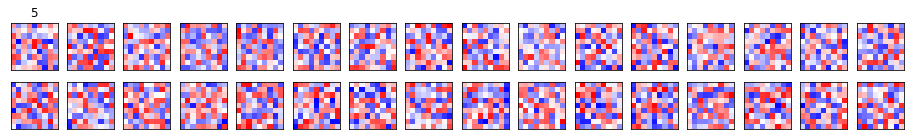

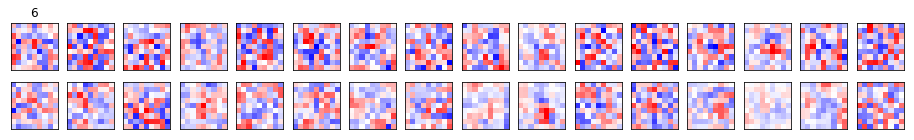

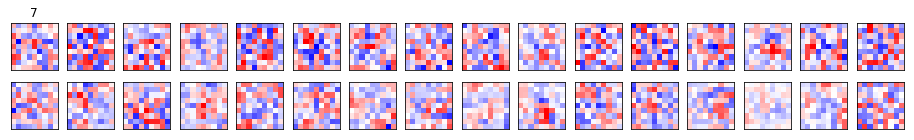

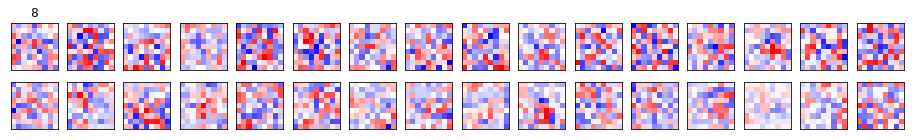

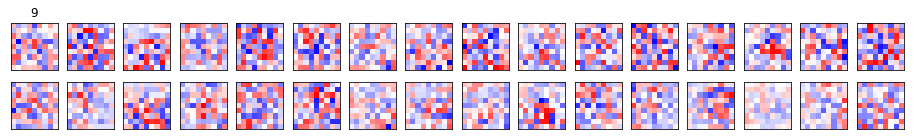

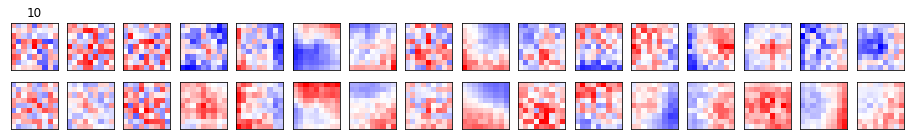

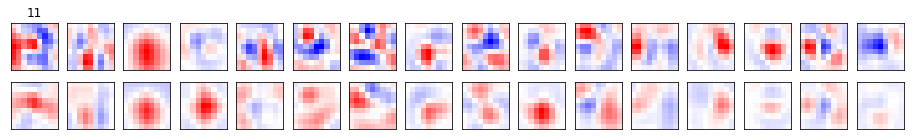

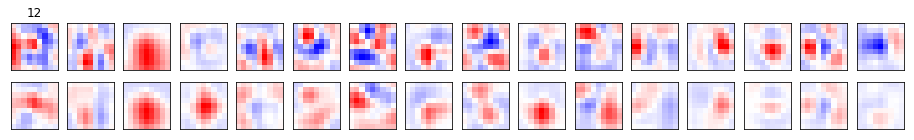

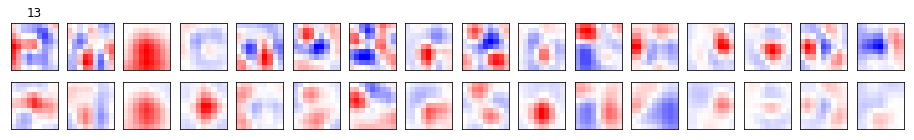

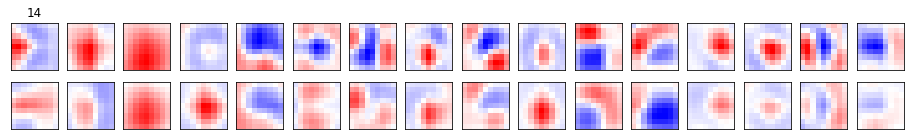

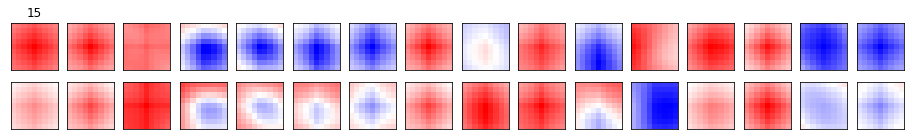

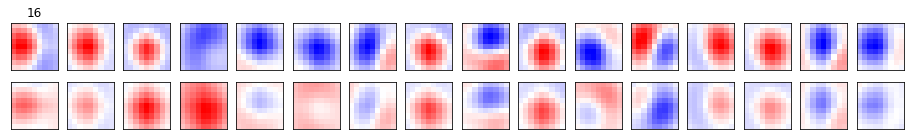

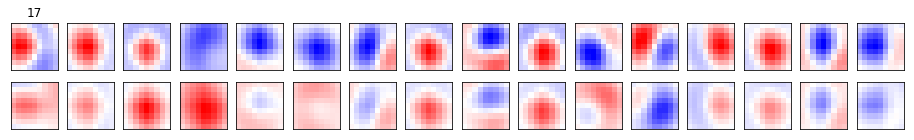

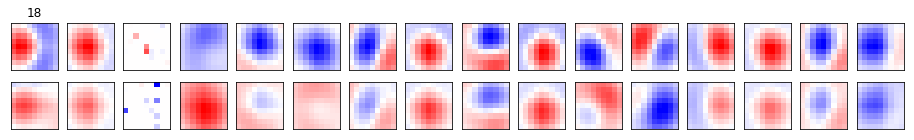

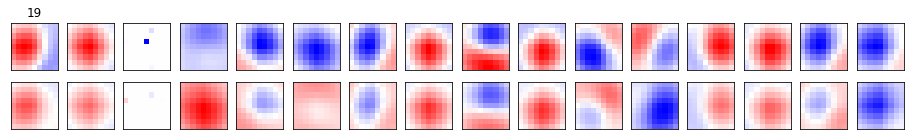

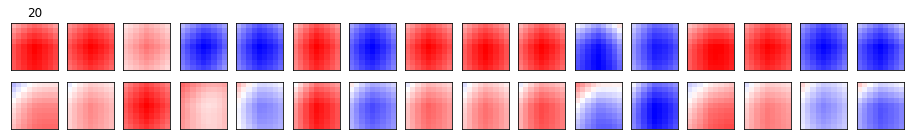

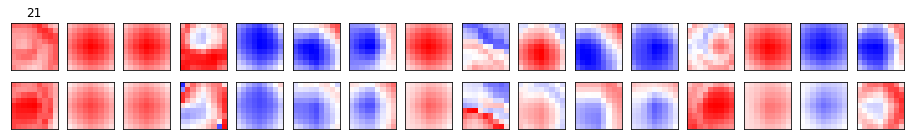

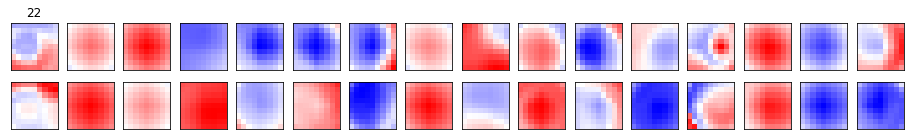

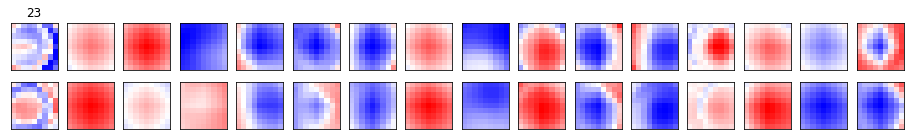

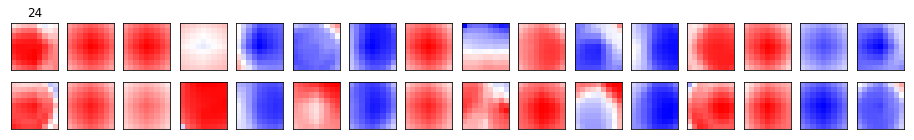

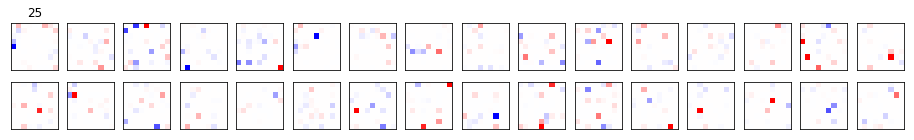

In [21]:
#visulize conv0 weights
modelname=np.arange(1,26)
plt.rcParams.update({'figure.max_open_warning': 0})
temptitle=1
for ii in range(len(modelname)):
    tempmodel= Autoencoder18_FC()
    tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+str(modelname[ii])+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.weight.cpu().data.numpy()
    Vis_conv3d_0(conv3d_0,temptitle)
    temptitle=temptitle+1
    torch.cuda.empty_cache()

# save example reconstruction results 

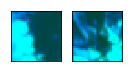

In [60]:
#save original input
x=val_loader
val_eg=279 
ncols=2
fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(ncols,1))
for jj in range(ncols):
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(x[val_eg+jj],(1,2,0))[...,::-1]
    axes[jj].imshow(img_real2view(temp))
    axes[jj].grid(False)#axes[ii,jj].axis('tight')
    axes[jj].set_xticks([]),axes[jj].set_yticks([])

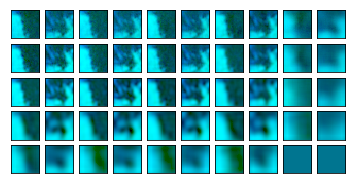

In [62]:
def Save_example_recon_output(filename): # 2 example outputs for each regularization
    fig,axes=plt.subplots(nrows=5,ncols=10,figsize=(6,3))
    for ii in range(5): #L2 regularization
        for jj in range(5): #L1 regularization
            modelnum=str(ii*5+jj+1) #select model
            tempmodel= Autoencoder18_FC()
            tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+modelnum+'.pth',map_location='cpu'))
            tempmodel=tempmodel.to(device_cpu)
            tempmodel=tempmodel.eval()
            data=val_loader/255.0
            val_eg=279
            x=data
            x[:,0,:,:]=x[:,0,:,:]-sky_bg_mean_f[0]
            x[:,1,:,:]=x[:,1,:,:]-sky_bg_mean_f[1]
            b_x = torch.from_numpy(x).float().to(device_cpu) 
            b_y = torch.from_numpy(x).float().to(device_cpu)
            encoded,decoded = tempmodel(b_x)
            del tempmodel
            #predict
            decoded_np=decoded.cpu().data.numpy()
            decoded_np[:,0,:,:]=decoded_np[:,0,:,:]+sky_bg_mean_f[0]
            decoded_np[:,1,:,:]=decoded_np[:,1,:,:]+sky_bg_mean_f[1]
            decoded_np= np.clip(decoded_np, 0.0, 1.0)
            for kk in range(2): # 2 example outputs
                temp=np.zeros((28,28,3),np.uint8) # 1st example
                temp[...,1:]=np.uint8(np.transpose(decoded_np[val_eg+kk],(1,2,0))[...,::-1]*255)
                axes[ii,jj*2+kk].imshow(img_real2view(temp))
                axes[ii,jj*2+kk].set_xticks([]),axes[ii,jj*2+kk].set_yticks([])
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.5]) #([0.85, 0.15, 0.03, 0.5])
    #ticks=np.linspace(weight_min,weight_max,4,endpoint=True)
    #fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%.4f")
    #fig.savefig(filename) 
    
Save_example_recon_output('out_result/ae_18_FC_upper_thresh_mse_example_recon_output.svg')

In [18]:
def model_eval_mse_ssim(model,data,device): #evaluate a model
    model=model.to(device)
    model=model.eval()
    data=data/255.0
    x=np.copy(data)
    x[:,0,:,:]=x[:,0,:,:]-sky_bg_mean_f[0]
    x[:,1,:,:]=x[:,1,:,:]-sky_bg_mean_f[1]
    b_x = torch.from_numpy(x).float().to(device) 
    b_y = torch.from_numpy(x).float().to(device)
    encoded,decoded = model(b_x)
    decoded_np=decoded.cpu().data.numpy()
    mse =np.mean((x-decoded_np)**2)
    x2=np.transpose(data,(0,2,3,1))
    decoded_np[:,0,:,:]=decoded_np[:,0,:,:]+sky_bg_mean_f[0]
    decoded_np[:,1,:,:]=decoded_np[:,1,:,:]+sky_bg_mean_f[1]
    decoded_np2=np.transpose(decoded_np,(0,2,3,1))
    ssims=np.zeros((len(decoded_np2)))
    for ii in range(len(decoded_np2)):
        ssims[ii]=measure.compare_ssim(x2[ii], decoded_np2[ii], data_range=1,multichannel=True)
    return mse,np.mean(ssims)
def eval_all_models(data):
    results_mse=np.zeros((5,5))
    results_ssim=np.zeros((5,5))
    for ii in range(5): #L2 regularization
        for jj in range(5): #L1 regularization
            modelnum=str(ii*5+jj+1) #select model
            tempmodel= Autoencoder18_FC()
            tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+modelnum+'.pth',map_location='cpu'))
            tempmodel=tempmodel.to(device_cpu)
            tempmodel=tempmodel.eval()
            results_mse[ii,jj],results_ssim[ii,jj]=model_eval_mse_ssim(tempmodel,data,device_cpu)
            del tempmodel
    return results_mse,results_ssim
#
results_mse,results_ssim=eval_all_models(data=np.concatenate((val_loader,test_loader),axis=0))
print (results_mse)
print (results_ssim)

[[0.00379916 0.00504896 0.00450147 0.00527869 0.01203711]
 [0.00243803 0.00319225 0.00402211 0.00389806 0.01371143]
 [0.00260112 0.00276334 0.0034051  0.00476187 0.01674779]
 [0.00588874 0.00580083 0.00627863 0.00772591 0.0206031 ]
 [0.01320903 0.01287989 0.01365046 0.01517242 0.04336103]]
[[0.8198757  0.77658697 0.78149485 0.75343098 0.52430564]
 [0.85508748 0.83213916 0.8182302  0.79847677 0.49357945]
 [0.86503425 0.86572923 0.83898836 0.77276511 0.44786233]
 [0.72199914 0.7169969  0.69661651 0.64427776 0.41236761]
 [0.52690001 0.5283618  0.51394978 0.4777494  0.29010675]]


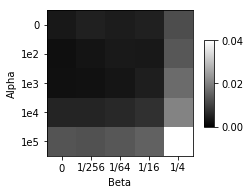

In [20]:
#mse
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
im=axes.imshow(results_mse,vmin=0,vmax=0.04,cmap='gray' )
axes.set_xticks([0,1,2,3,4])
axes.set_yticks([0,1,2,3,4])
axes.set_xlabel('Beta')
axes.set_ylabel('Alpha')
axes.set_xticklabels(['0','1/256','1/64','1/16','1/4'])
axes.set_yticklabels(['0','1e2',  '1e3', '1e4', '1e5'])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
ticks=[0,0.02,0.04]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%.2f")

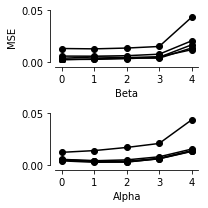

In [29]:
#mse
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(3,3))
for ii in range(5):
    axes[0].plot(results_mse[ii,:],'ko',linestyle='-') #against beta
    axes[1].plot(results_mse[:,ii],'ko',linestyle='-') #against alpha
axes[0].set_xlabel('Beta')
axes[1].set_xlabel('Alpha')
axes[0].set_ylabel('MSE')
axes[0].set_xticks([0,1,2,3,4])
axes[1].set_xticks([0,1,2,3,4])
axes[0].set_yticks([0,0.05])
axes[1].set_yticks([0,0.05])
adjust_spines(axes[0], ['left', 'bottom'])
adjust_spines(axes[1], ['left', 'bottom'])
fig.tight_layout()

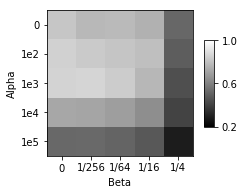

In [65]:
#ssim
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(3,3))
im=axes.imshow(results_ssim,vmin=0.2,vmax=1,cmap='gray' )
axes.set_xticks([0,1,2,3,4])
axes.set_yticks([0,1,2,3,4])
axes.set_xlabel('Beta')
axes.set_ylabel('Alpha')
axes.set_xticklabels(['0','1/256','1/64','1/16','1/4'])
axes.set_yticklabels(['0','1e2',  '1e3', '1e4', '1e5'])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
ticks=[0.2,0.6,1]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%.1f")

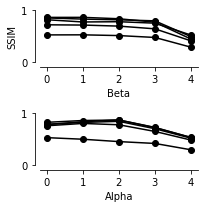

In [45]:
#ssim
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(3,3))
for ii in range(5):
    axes[0].plot(results_ssim[ii,:],'ko',linestyle='-') #against beta
    axes[1].plot(results_ssim[:,ii],'ko',linestyle='-') #against alpha
axes[0].set_xlabel('Beta')
axes[1].set_xlabel('Alpha')
axes[0].set_ylabel('SSIM')
axes[0].set_xticks([0,1,2,3,4])
axes[1].set_xticks([0,1,2,3,4])
axes[0].set_yticks([0,1])
axes[1].set_yticks([0,1])
adjust_spines(axes[0], ['left', 'bottom'])
adjust_spines(axes[1], ['left', 'bottom'])
fig.tight_layout()

# save example RFs for all regularizations

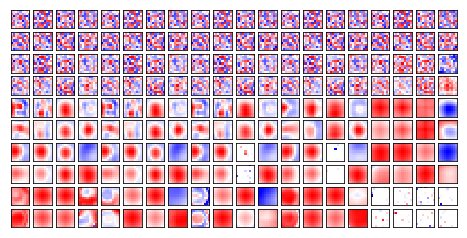

In [66]:
def Save_example_conv3d_0(filename): # 4 example RFs for each regularization
    fig,axes=plt.subplots(nrows=10,ncols=20,figsize=(8,4))
    for ii in range(5): #L2 regularization
        for jj in range(5):
            modelnum=str(ii*5+jj+1) #select model
            tempmodel= Autoencoder18_FC()
            tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+modelnum+'.pth',map_location='cpu'))
            tempmodel=tempmodel.to(device_cpu)
            conv3d_0=tempmodel.conv1.weight.cpu().data.numpy() #get RFs
            del tempmodel
            for kk in range(4): # 4 example RFs
                weightmax=np.max(np.abs(conv3d_0[kk,...]))
                axes[ii*2,jj*4+kk].imshow(conv3d_0[kk,0,...],vmin=-weightmax,vmax=weightmax,cmap='bwr')#UV
                axes[ii*2,jj*4+kk].set_xticks([]),axes[ii*2,jj*4+kk].set_yticks([])
                axes[ii*2+1,jj*4+kk].imshow(conv3d_0[kk,1,...],vmin=-weightmax,vmax=weightmax,cmap='bwr')#G
                axes[ii*2+1,jj*4+kk].set_xticks([]),axes[ii*2+1,jj*4+kk].set_yticks([])
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.5]) #([0.85, 0.15, 0.03, 0.5])
    #ticks=np.linspace(weight_min,weight_max,4,endpoint=True)
    #fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%.4f")
    #fig.savefig(filename)     
Save_example_conv3d_0('out_result/ae_18_FC_upper_thresh_mse_example_conv3d_0_bwr.svg')

# save nice RFs

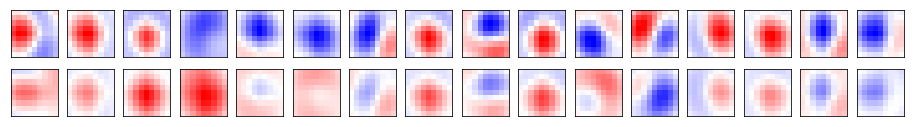

In [68]:
#save nice RFs
tempmodel= Autoencoder18_FC()
tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+str(17)+'.pth',map_location='cpu'))
tempmodel=tempmodel.to(device_cpu)
conv3d_0=tempmodel.conv1.weight.cpu().data.numpy()
del tempmodel
def Save_conv3d_0(conv3d_0,filename):
    (outd,ind,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=2, ncols=outd,figsize=(outd, 2))
    for jj in range(outd):
        weightmax=np.max(np.abs(conv3d_0[jj,...]))
        axes[0,jj].imshow(conv3d_0[jj,0,...],vmin=-weightmax,vmax=weightmax,cmap='bwr')#UV
        axes[0,jj].set_xticks([]),axes[0,jj].set_yticks([])
        im=axes[1,jj].imshow(conv3d_0[jj,1,...],vmin=-weightmax,vmax=weightmax,cmap='bwr')#G
        axes[1,jj].set_xticks([]),axes[1,jj].set_yticks([])
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.5]) #([0.85, 0.15, 0.03, 0.5])
    #ticks=np.linspace(weight_min,weight_max,4,endpoint=True)
    #fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%.4f")
    #fig.savefig(filename)    
#Save_conv3d_0(conv3d_0,'out_result/ae_18_FC_upper_thresh_mse_17_conv3d_0_bwr.svg')

# CC values between UV and G

In [18]:
#CC values
tempmodel= Autoencoder18_FC()
tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+str(17)+'.pth',map_location='cpu'))
tempmodel=tempmodel.to(device_cpu)
conv3d_0=tempmodel.conv1.weight.cpu().data.numpy()
del tempmodel
(outd,ind,_,_)=conv3d_0.shape
CCs_upper_11=np.zeros(outd)
pVs_upper_11=np.zeros(outd)
for ii in range(outd):
    CCs_upper_11[ii],pVs_upper_11[ii]=pearsonr(conv3d_0[ii,0,...].flatten(),conv3d_0[ii,1,...].flatten())
print (CCs_upper_11)
print (pVs_upper_11)

[ 0.58205579  0.98739225  0.98319238 -0.47366056  0.89855224  0.52844517
  0.97269247  0.9904519   0.98738014  0.97939696  0.81198065  0.87913732
  0.97178427  0.97929447  0.96970196  0.95689168]
[1.20312290e-08 5.18218131e-65 4.09580645e-60 7.96287842e-06
 5.51071040e-30 3.96499917e-07 7.10349311e-52 9.35660881e-70
 5.38117929e-65 1.18550544e-56 3.69439758e-20 3.78475596e-27
 2.54224634e-51 1.43940298e-56 4.06883477e-50 3.56820147e-44]


In [17]:
#CC values for all models
modelnames=np.arange(1,26)
for modelname in modelnames:
    tempmodel= Autoencoder18_FC()
    tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+str(modelname)+'.pth',map_location='cpu'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.weight.cpu().data.numpy()
    del tempmodel
    (outd,ind,_,_)=conv3d_0.shape
    CCs_upper_7=np.zeros(outd)
    pVs_upper_7=np.zeros(outd) 
    for ii in range(outd):
        CCs_upper_7[ii],pVs_upper_7[ii]=pearsonr(conv3d_0[ii,0,...].flatten(),conv3d_0[ii,1,...].flatten())
    print ('Model: %d' %(modelname))
    print (CCs_upper_7)
    print (pVs_upper_7)
    print ('/n')

Model: 1
[-0.00186932 -0.00866504 -0.02370565 -0.07294972  0.20326053  0.20632875
 -0.13846638 -0.05939073  0.01828576 -0.06754044 -0.06446296 -0.12933807
 -0.04970305  0.0102796   0.07115887 -0.06745986]
[0.98678571 0.93880279 0.83361748 0.5174986  0.06876498 0.06459723
 0.21765922 0.59842004 0.87128424 0.54910567 0.56749515 0.24981807
 0.65946838 0.92742838 0.52785957 0.54958351]
/n
Model: 2
[-0.01264256 -0.01864598 -0.0296316  -0.06579527  0.2029917   0.19542891
 -0.16133442 -0.07003321  0.02844198 -0.08651524 -0.07756934 -0.1419726
 -0.060668    0.01302821 -0.00032291 -0.06701192]
[0.91080832 0.86877093 0.79286117 0.55949849 0.06914024 0.08039063
 0.15018273 0.53442477 0.80100229 0.44250114 0.49125672 0.20611921
 0.59056228 0.90809928 0.99771725 0.55224326]
/n
Model: 3
[-0.02150704 -0.0147822  -0.03906266 -0.05243448  0.19673687  0.18504852
 -0.17298892 -0.08332252  0.05681511 -0.10048438 -0.08798096 -0.14742733
 -0.07326313  0.0139987  -0.0636693  -0.06456581]
[0.84885711 0.895791

In [25]:
#CC values for all models and list the indices with negative CC and pV <0.05
modelnames=np.arange(1,26)
for modelname in modelnames:
    tempmodel= Autoencoder18_FC()
    tempmodel.load_state_dict(torch.load('out/ae_18_FC_upper_thresh_mse_'+str(modelname)+'.pth',map_location='cpu'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.weight.cpu().data.numpy()
    del tempmodel
    (outd,ind,_,_)=conv3d_0.shape
    CCs_upper_7=np.zeros(outd)
    pVs_upper_7=np.zeros(outd) 
    for ii in range(outd):
        CCs_upper_7[ii],pVs_upper_7[ii]=pearsonr(conv3d_0[ii,0,...].flatten(),conv3d_0[ii,1,...].flatten())
    print ('Model: %d' %(modelname))
    opp_ind=np.where(CCs_upper_7<0)[0].tolist()
    pV_ind =np.where(pVs_upper_7<0.05)[0].tolist()
    opp_vP_ind=[opp_ind,pV_ind]
    opp_pV=set(opp_vP_ind[0]).intersection(*opp_vP_ind)
    print (opp_pV)
    print ('/n')

Model: 1
set()
/n
Model: 2
set()
/n
Model: 3
set()
/n
Model: 4
set()
/n
Model: 5
set()
/n
Model: 6
set()
/n
Model: 7
set()
/n
Model: 8
set()
/n
Model: 9
set()
/n
Model: 10
set()
/n
Model: 11
set()
/n
Model: 12
set()
/n
Model: 13
set()
/n
Model: 14
set()
/n
Model: 15
set()
/n
Model: 16
{3}
/n
Model: 17
{3}
/n
Model: 18
{3}
/n
Model: 19
set()
/n
Model: 20
set()
/n
Model: 21
set()
/n
Model: 22
{0}
/n
Model: 23
set()
/n
Model: 24
{3}
/n
Model: 25
{3}
/n
